# Analyse the PAIBB on UnRel

This notebook analyses and visualizes the results for **Percentage of Attentions Inside Bounding Boxes** (PAIBB) metric

In [1]:
import os
import re
import sys
import json
import random
random.seed(42)
from typing import Optional, Any
import warnings
warnings.filterwarnings("ignore")
from pathlib import Path

package_root = os.path.dirname(os.getcwd())
sys.path.insert(0, package_root)

import torch
torch.manual_seed(42)

import numpy as np
np.random.seed(42)

import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
import matplotlib.patches as patches
import seaborn as sns

sns.set(font_scale=1.4)
sns.set_style("whitegrid", {
    "grid.linestyle": 'dashed',
    "axes.edgecolor": '#475569',
    'font.family': ['sans-serif'],
    'font.sans-serif': [
        'Droid Sans',
        'sans-serif'
    ],
})
%matplotlib inline

unrel_path = Path(package_root) / "data" / "UnRel" 

# Load unrel_path annotation
with open(unrel_path / "instances_unrel.json") as f:
    unrel_annos = json.load(f)

In [3]:
annotations = unrel_annos['annotations']
def get_annos_for_img(img_id: int) -> Any:
    annos = filter(lambda x: x['image_id'] == img_id, annotations)
    return list(annos)

In [13]:
def read_data(fname: str):
    metric_dir = Path(package_root) / "unrel" / "outputs" / "metrics" / "paibb"

    data = []
    fpath = metric_dir / fname
    with open(fpath, "r") as f:
        for line in f:
            # Replace single quotes with double quotes for JSONEncoder to work
            line = line.replace("\'", "\"")
            item = json.loads(line)
            data.append(item)


    df = pd.DataFrame(data)
    return df

In [14]:
softmax_df = read_data("paibb_softmax.txt")
entmax15_df = read_data("paibb_entmax15.txt")
sparsemax_df = read_data("paibb_sparsemax.txt")
alpha_entmax_df = read_data("paibb_alpha_entmax.txt")

data = [
    {'model': 'softmax', 'mean': softmax_df['paibb'].mean(), 'std': softmax_df['paibb'].std()},
    {'model': 'entmax15', 'mean': entmax15_df['paibb'].mean(), 'std': entmax15_df['paibb'].std()},
    {'model': 'sparsemax', 'mean': sparsemax_df['paibb'].mean(), 'std': sparsemax_df['paibb'].std()},
    {'model': 'alpha_entmax', 'mean': alpha_entmax_df['paibb'].mean(), 'std': alpha_entmax_df['paibb'].std()},
]

df = pd.DataFrame(data)

[Text(0, 0, '0.551831'),
 Text(0, 0, '0.446862'),
 Text(0, 0, '0.577657'),
 Text(0, 0, '0.553313')]

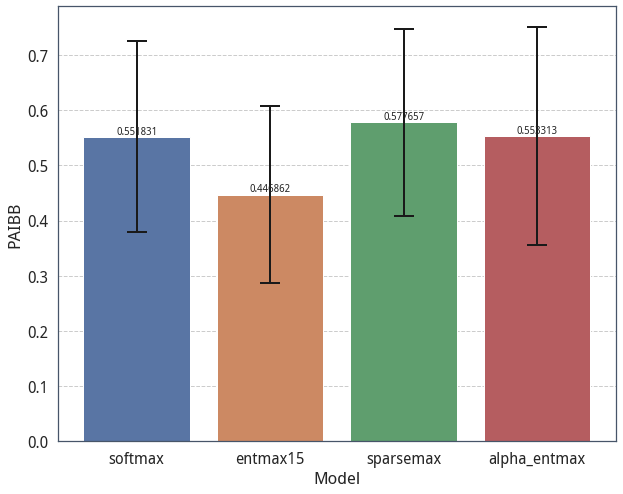

In [15]:
fig, ax = plt.subplots(figsize=(10, 8))
sax = sns.barplot(data=df, x='model', y='mean', ax=ax)

ax.set_xlabel("Model")
ax.set_ylabel("PAIBB")
x_coords = [p.get_x() + 0.5 * p.get_width() for p in sax.patches]
y_coords = [p.get_height() for p in sax.patches]
plt.errorbar(x=x_coords, y=y_coords, yerr=df['std'], fmt="none", c="k", capsize=10, elinewidth=2, markeredgewidth=2)
sax.bar_label(sax.containers[0])

In [16]:
def get_stat(frame):
    small_df = frame[frame.gt_area < 32*32]
    medium_df = frame[(frame.gt_area >= 32*32) & (frame.gt_area <= 96*96)]
    large_df = frame[frame.gt_area > 96*96]
    return {
        "small_mean": small_df['paibb'].mean(),
        "small_std": small_df['paibb'].std(),
        "medium_mean": medium_df['paibb'].mean(),
        "medium_std": medium_df['paibb'].std(),
        "large_mean": large_df['paibb'].mean(),
        "large_std": large_df['paibb'].std(),
    }

In [19]:
data = [
    {'model': 'softmax', **get_stat(softmax_df)},
    {'model': 'entmax15', **get_stat(entmax15_df)},
    {'model': 'sparsemax', **get_stat(sparsemax_df)},
    {'model': 'alpha_entmax', **get_stat(alpha_entmax_df)}
]
data

[{'model': 'softmax',
  'small_mean': 0.1657295399407889,
  'small_std': 0.1603063442796247,
  'medium_mean': 0.38110900475311577,
  'medium_std': 0.1694129687505101,
  'large_mean': 0.5884404909770353,
  'large_std': 0.14499626187618672},
 {'model': 'entmax15',
  'small_mean': 0.1500062802160293,
  'small_std': 0.14226601944614437,
  'medium_mean': 0.32627841374435085,
  'medium_std': 0.14853181776772967,
  'large_mean': 0.47323086000746284,
  'large_std': 0.14654899796747292},
 {'model': 'sparsemax',
  'small_mean': 0.2004519067763872,
  'small_std': 0.1854135974756403,
  'medium_mean': 0.4331106309562162,
  'medium_std': 0.18687581695283,
  'large_mean': 0.6097195270149608,
  'large_std': 0.14244955828865458},
 {'model': 'alpha_entmax',
  'small_mean': 0.14572046739636266,
  'small_std': 0.13904331689959398,
  'medium_mean': 0.34537382317836907,
  'medium_std': 0.16195254834932532,
  'large_mean': 0.5965769230518476,
  'large_std': 0.1696920035532583}]

In [20]:
for item in data:
    str_line = item['model'] + " & "
    s_mean = item['small_mean'] * 100
    m_mean = item['medium_mean'] * 100
    l_mean = item['large_mean'] * 100
    str_line += f"${s_mean:.2f}$ & ${m_mean:.2f}$ & ${l_mean:.2f}$ \\\\"

    print(str_line)

softmax & $16.57$ & $38.11$ & $58.84$ \\
entmax15 & $15.00$ & $32.63$ & $47.32$ \\
sparsemax & $20.05$ & $43.31$ & $60.97$ \\
alpha_entmax & $14.57$ & $34.54$ & $59.66$ \\
